### BRSET

* [Dataset](https://physionet.org/content/brazilian-ophthalmological/1.0.0/)

* [Original Paper](https://www.medrxiv.org/content/10.1101/2024.01.23.24301660v1)

In [3]:
%cd ..

/home/datascience/Data Fusion


### Setup Environment:

In [4]:
import os
import pandas as pd

from src.classifiers import preprocess_data, process_labels,split_data

from src.classifiers import VQADataset
from torch.utils.data import DataLoader

from src.classifiers_cpu_metrics import train_early_fusion, train_late_fusion

In [5]:
PATH = 'Embeddings/brset/'
COLUMN = 'embeddings'

## Get data

In [11]:
df = pd.read_csv(os.path.join(PATH, 'embeddings.csv'))
df.head()

,DR_ICDR,DR_2,DR_3,split,text_1,text_2,text_3,text_4,text_5,text_6,...,image_758,image_759,image_760,image_761,image_762,image_763,image_764,image_765,image_766,image_767
0,0,0,0,train,-0.230976,-0.649306,0.351964,4.827357,-0.652423,-1.548302,...,0.353415,-2.146708,-1.749919,-1.179385,1.859870,2.456600,-0.001963,-1.731499,0.635826,-2.967020
1,0,0,0,test,-0.188945,-0.516513,0.458152,4.739528,-0.524881,-1.532104,...,-0.184760,-0.907411,-2.038369,-1.021670,1.608807,1.900826,-0.817061,-1.813032,0.369190,-2.460825
2,0,0,0,train,-0.690169,-0.710446,0.562674,4.909813,-0.266062,-1.765767,...,-0.754568,-1.555292,-2.267442,-2.331255,2.976459,-0.276913,-0.815998,-0.846560,0.259764,-1.921576
3,0,0,0,train,-0.748607,-0.507840,0.673932,4.859914,-0.071180,-1.733303,...,-0.992413,-1.933622,-1.661158,-1.502459,2.131441,0.620160,-0.455107,-1.403641,0.617730,-2.241285
4,0,0,0,test,-0.575935,-0.649872,0.722284,5.002320,-0.277846,-1.737345,...,-0.895002,-1.292191,-1.858146,-1.470159,2.455127,1.181771,-0.773389,-1.061603,-0.579806,-2.569620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16261,1,1,1,test,-0.156000,-0.576070,0.518733,4.860677,-0.548927,-1.658503,...,-1.179304,0.053831,-2.046273,-1.303568,1.769838,1.404540,-1.681622,-1.509749,-0.439706,-1.182712
16262,0,0,0,train,-0.662821,-0.798594,0.822011,5.000335,-0.311123,-1.738856,...,-0.638783,-2.080983,-2.094080,-1.227005,1.760412,1.417876,0.782354,-1.448640,0.192680,-2.111981
16263,0,0,0,test,-0.710576,-0.633989,0.919676,4.877810,-0.200884,-1.763229,...,-0.794986,-1.573541,-2.704950,-1.622533,1.921694,1.104099,0.897089,-1.335263,0.926274,-1.834079
16264,0,0,0,train,0.040444,-0.434922,0.814571,4.971009,-0.718888,-2.269104,...,-1.771810,-1.364439,-2.600565,-1.916687,3.070501,0.102725,-0.336407,-1.173584,1.082957,-1.850800


## Data Perparation

In [7]:
# Split the data
train_df, test_df = split_data(df)

# Select features and labels vectors
text_columns = [column for column in df.columns if 'text' in column] #[f'text_{i}']
image_columns = [column for column in df.columns if 'image' in column] #[f'image_{i}']
label_columns = 'DR_2'


# Process and one-hot encode labels for training set
train_labels, mlb, train_columns = process_labels(train_df, col=label_columns)
test_labels = process_labels(test_df, col=label_columns, train_columns=train_columns)


train_dataset = VQADataset(train_df, text_columns, image_columns, label_columns, mlb, train_columns)
test_dataset = VQADataset(test_df, text_columns, image_columns, label_columns, mlb, train_columns)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Train Shape: (13012, 4868)
Test Shape: (3254, 4868)


### Models

In [8]:
text_input_size = len(text_columns)
image_input_size = len(image_columns)
if label_columns == 'DR_2':
    output_size = 1
else:
    output_size = len(pd.unique(train_df[label_columns]))
multilabel = False

Training Early Fusion Model:
Model Memory Usage: 2.38 MB
The number of parameters of the model are: 623105


STAGE:2024-02-09 05:02:24 23391:23391 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


Epoch 1/30 - Test Accuracy: 0.9809, macro-f1: 0.9225
Epoch 1/30 - Training Time: 1.26 seconds | Inference Time: 0.33 seconds
Epoch 2/30 - Test Accuracy: 0.9822, macro-f1: 0.9177
Epoch 2/30 - Training Time: 1.45 seconds | Inference Time: 0.36 seconds
Epoch 3/30 - Test Accuracy: 0.9852, macro-f1: 0.9339
Epoch 3/30 - Training Time: 1.44 seconds | Inference Time: 0.35 seconds
Epoch 4/30 - Test Accuracy: 0.9868, macro-f1: 0.9437
Epoch 4/30 - Training Time: 1.51 seconds | Inference Time: 0.37 seconds
Epoch 5/30 - Test Accuracy: 0.9828, macro-f1: 0.9221
Epoch 5/30 - Training Time: 1.66 seconds | Inference Time: 0.38 seconds
Epoch 6/30 - Test Accuracy: 0.9843, macro-f1: 0.9313
Epoch 6/30 - Training Time: 1.63 seconds | Inference Time: 0.38 seconds
Epoch 7/30 - Test Accuracy: 0.9831, macro-f1: 0.9237
Epoch 7/30 - Training Time: 1.48 seconds | Inference Time: 0.36 seconds
Epoch 8/30 - Test Accuracy: 0.9828, macro-f1: 0.9229
Epoch 8/30 - Training Time: 1.64 seconds | Inference Time: 0.39 seconds


STAGE:2024-02-09 05:03:28 23391:23391 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-02-09 05:03:28 23391:23391 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                         training_batch         8.87%        4.429s        64.56%       32.244s       5.269ms      -7.09 Gb      -7.10 Gb          6120  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...        28.60%       14.286s        29.06%       14.517s       1.883ms       8.84 Gb       8.84 Gb          7710  
                              Optimizer.step#AdamW.step         4.83%        2.412s        20.23%       10.105s       1.651ms       4.75 Mb     -28.11

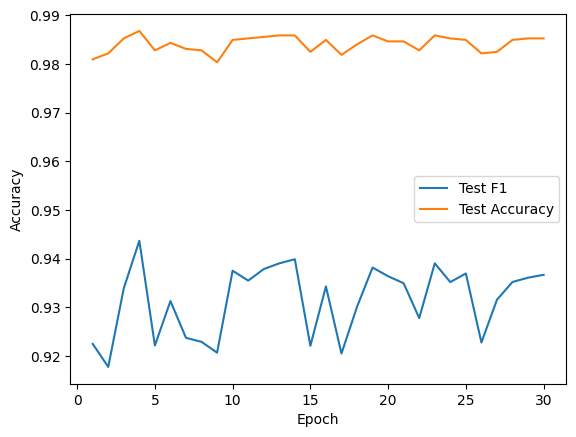

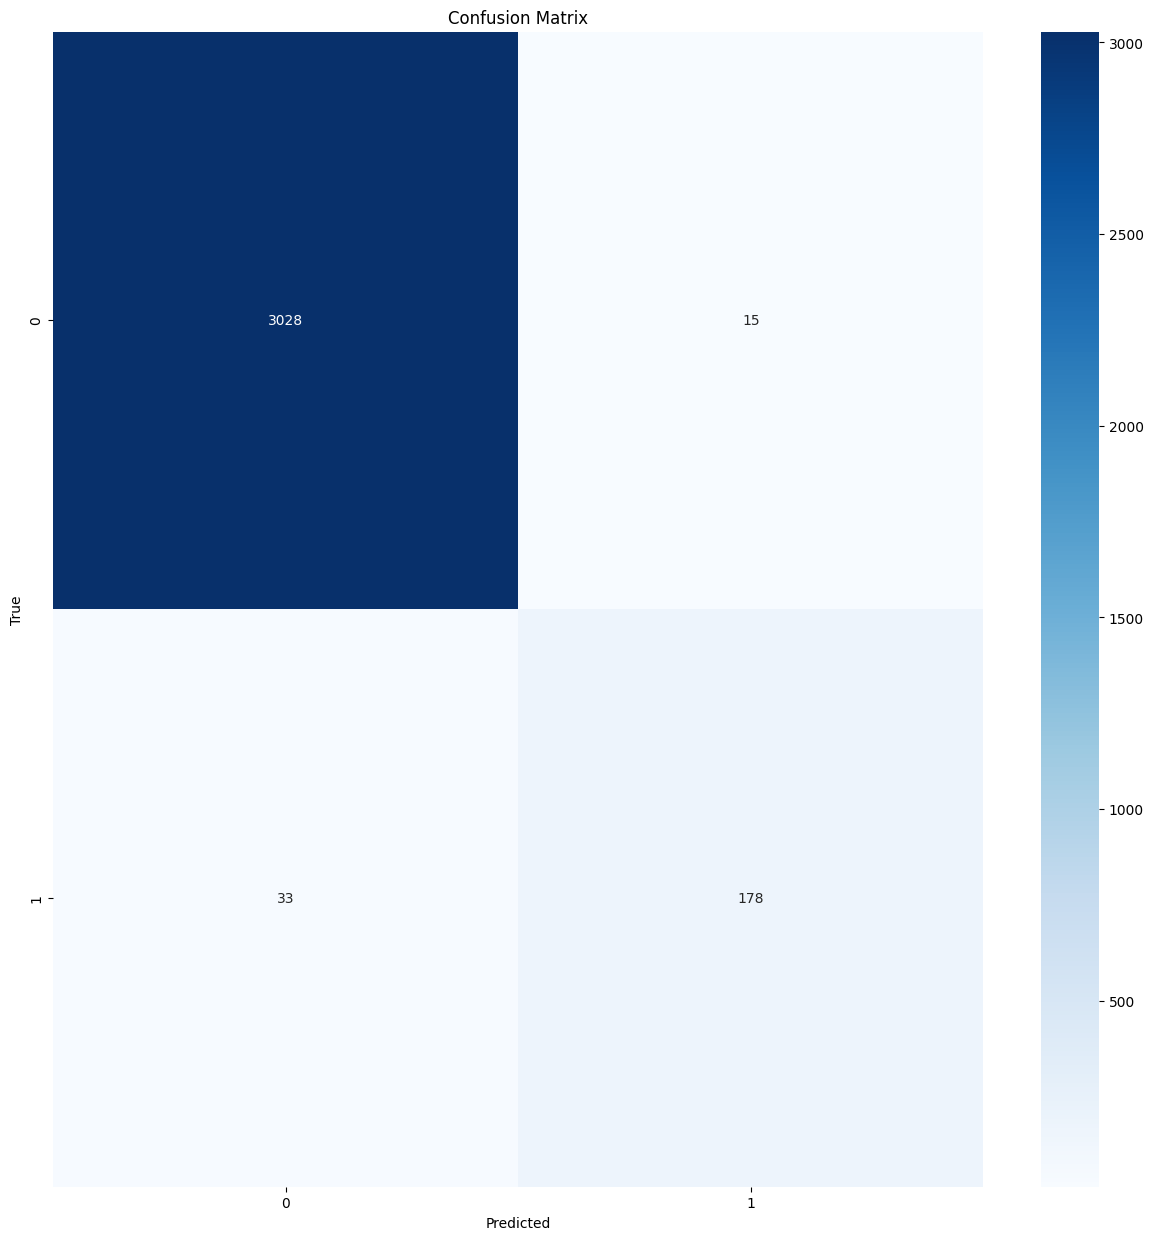

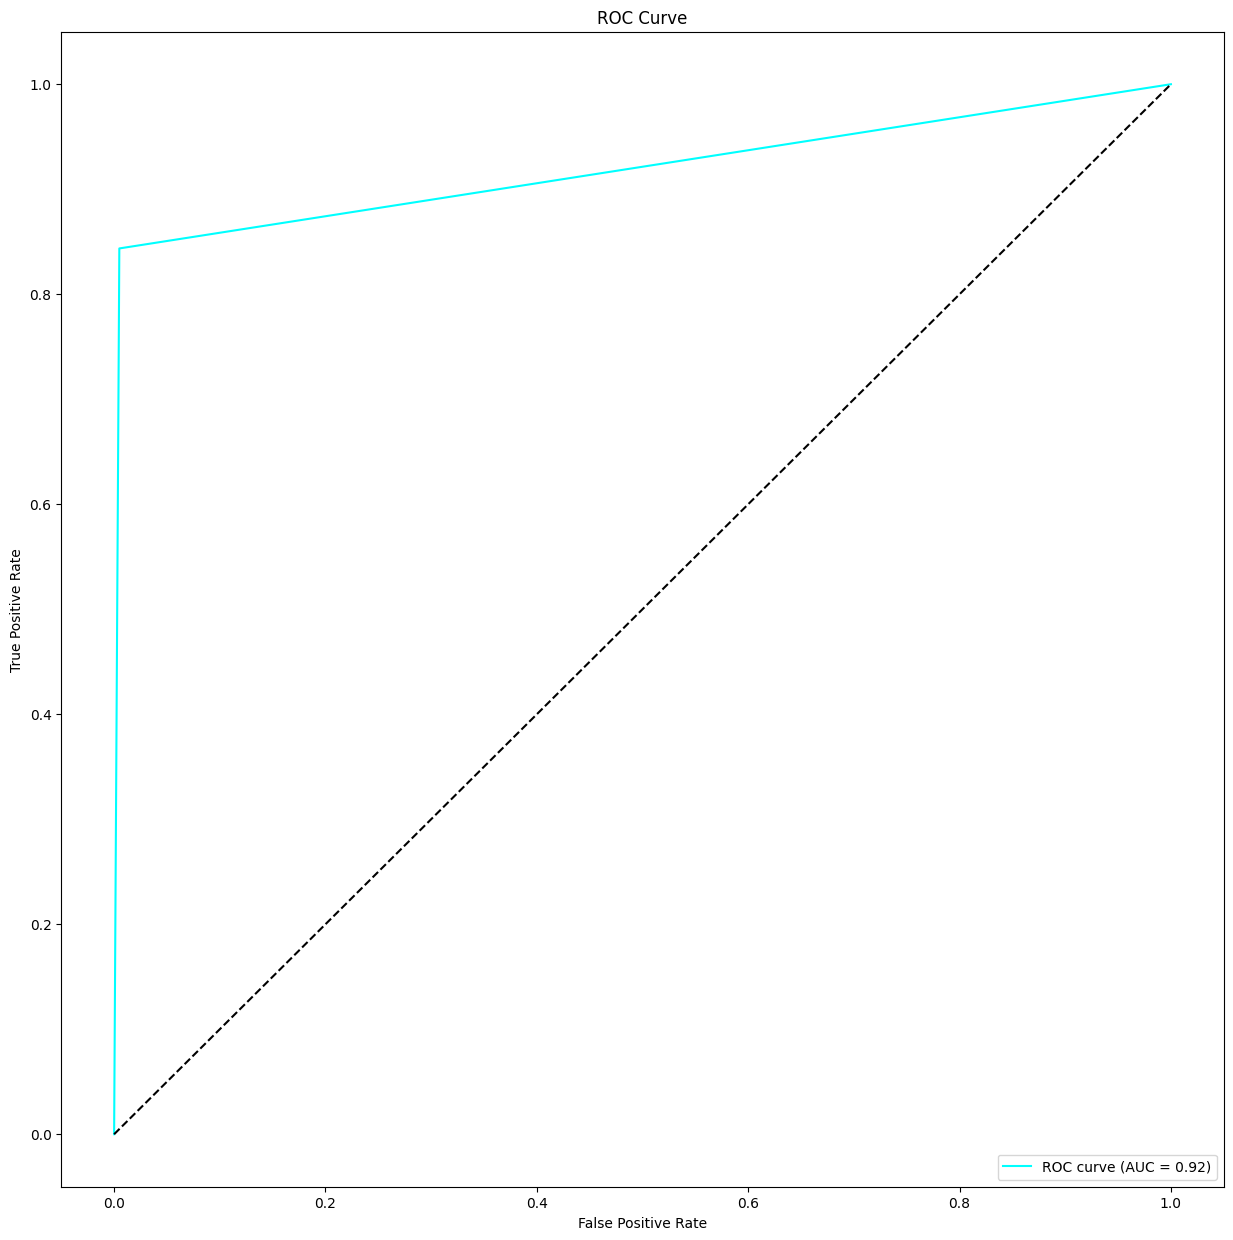

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      3043
         1.0       0.92      0.84      0.88       211

    accuracy                           0.99      3254
   macro avg       0.96      0.92      0.94      3254
weighted avg       0.98      0.99      0.98      3254



In [9]:
# Train early fusion model
print("Training Early Fusion Model:")
train_early_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=30, multilabel=multilabel, report=True)

Training Late Fusion Model:
Model Memory Usage: 1.19 MB
The number of parameters of the model are: 311809


STAGE:2024-02-09 05:07:53 23391:23391 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


Epoch 1/30 - Test Accuracy: 0.9816, macro-f1: 0.9223
Epoch 1/30 - Training Time: 2.10 seconds | Inference Time: 0.75 seconds
Epoch 2/30 - Test Accuracy: 0.9849, macro-f1: 0.9358
Epoch 2/30 - Training Time: 1.99 seconds | Inference Time: 0.71 seconds
Epoch 3/30 - Test Accuracy: 0.9822, macro-f1: 0.9290
Epoch 3/30 - Training Time: 1.87 seconds | Inference Time: 0.70 seconds
Epoch 4/30 - Test Accuracy: 0.9865, macro-f1: 0.9417
Epoch 4/30 - Training Time: 1.99 seconds | Inference Time: 0.71 seconds
Epoch 5/30 - Test Accuracy: 0.9852, macro-f1: 0.9358
Epoch 5/30 - Training Time: 2.00 seconds | Inference Time: 0.71 seconds
Epoch 6/30 - Test Accuracy: 0.9859, macro-f1: 0.9384
Epoch 6/30 - Training Time: 1.89 seconds | Inference Time: 0.70 seconds
Epoch 7/30 - Test Accuracy: 0.9819, macro-f1: 0.9257
Epoch 7/30 - Training Time: 1.75 seconds | Inference Time: 0.71 seconds
Epoch 8/30 - Test Accuracy: 0.9852, macro-f1: 0.9381
Epoch 8/30 - Training Time: 1.68 seconds | Inference Time: 0.71 seconds


STAGE:2024-02-09 05:09:19 23391:23391 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-02-09 05:09:19 23391:23391 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                         training_batch        11.32%        5.851s        65.34%       33.760s       4.413ms      -8.84 Gb      -8.85 Gb          7650  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...        34.20%       17.671s        34.62%       17.888s       2.320ms       8.84 Gb       8.84 Gb          7710  
                              Optimizer.step#AdamW.step         6.48%        3.347s        28.80%       14.879s       2.431ms       2.38 Mb     -14.07

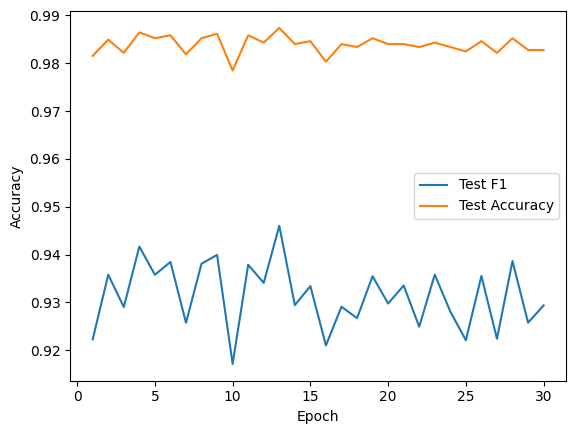

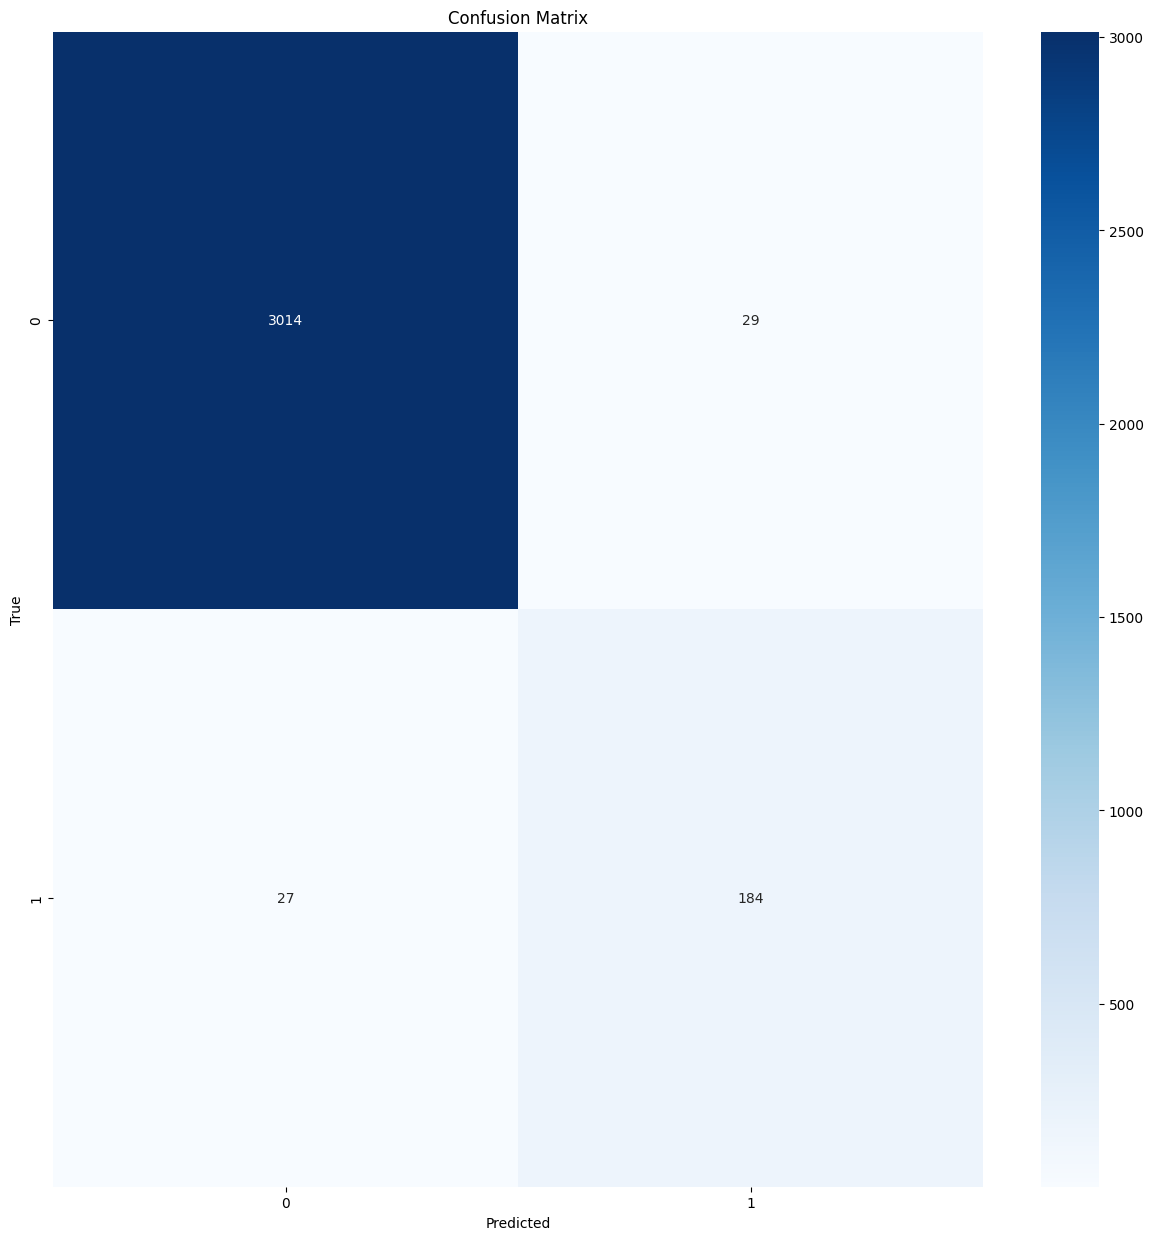

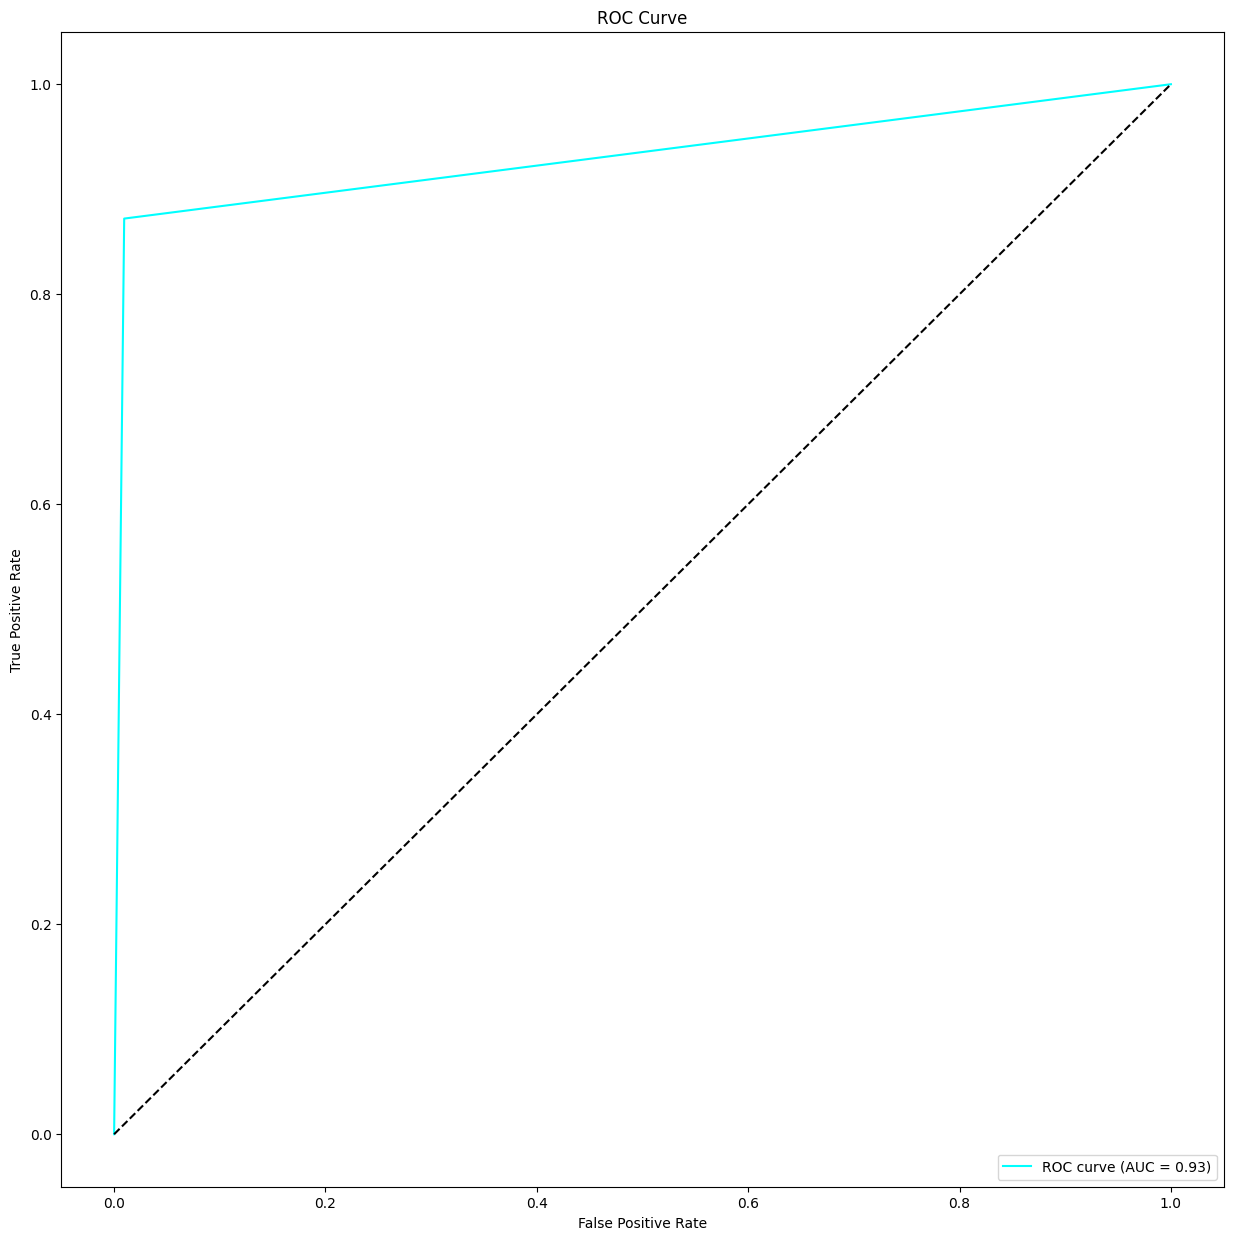

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3043
         1.0       0.86      0.87      0.87       211

    accuracy                           0.98      3254
   macro avg       0.93      0.93      0.93      3254
weighted avg       0.98      0.98      0.98      3254



In [10]:
# Train late fusion model
print("Training Late Fusion Model:")
train_late_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=30, multilabel=multilabel, report=True)